In [1]:
import numpy as np
from IPython.display import Audio
import librosa, librosa.display
import scipy
import matplotlib.pyplot as plt
import pandas as pd
import os
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MinMaxScaler
from audiomentations import Compose, AddGaussianNoise, Gain, PitchShift, Shift
import torch
import torchvision
from torchinfo import summary
from torch.utils.data import DataLoader, Dataset
import torchaudio
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms as T
from tqdm.notebook import tqdm, trange
import time

In [2]:
def get_mel_spectrogram(samples: np.array, sr: int = 44100, 
                        ) -> np.array:
    """
    :param samples (np.array): samples array of the audio
    :param sr (int): sample rate used for the samples
    :return mel_spectrogram (np.array): np.array containing 
                                      melspectrogram features in decibels
    """
    hop_length = len(samples)//256
    
    # get mel spectrogram image data
    mel_features = librosa.feature.melspectrogram(
        y=samples, sr=sr, hop_length=hop_length, n_mels=256)
    
    # clip the array to fit our target image shape
    mel_features = mel_features[:, :256]
    
    # convert to decibels as and normalize the image for efficiency
    mel_in_db = librosa.power_to_db(mel_features, ref=np.max)
    scaler = MinMaxScaler(feature_range=(0, 1))
    return scaler.fit_transform(mel_in_db)

In [3]:
def apply_augmentation(samples: np.array):

    gaussian_noise = AddGaussianNoise(
        min_amplitude=0.001,
        max_amplitude= 0.015,
        p=0.5
    )
    time_shift = Shift(
        min_fraction=-0.2,
        max_fraction=0.2,
        rollover=False,
        fade=True,
        p=0.5
    )
    pitch_shift = PitchShift(
        min_semitones=-0.5,
        max_semitones=0.5,
        p=0.25
    )
    gain = Gain(p=0.5)
    augmenter = Compose(
        [time_shift, gain, pitch_shift, gaussian_noise])
    return augmenter(samples=samples,
                     sample_rate=44100)

In [213]:
dataset_path = 'AVP-LVT_Dataset\AVP_Dataset\Personal'
dataset = pd.DataFrame(columns = ['Specs','Label', 'Audio'])

for subdir,_,files in os.walk(dataset_path):
    for filename in (files): 
        
        if filename.endswith('.csv'):
            onset_csv = pd.read_csv(os.path.join(subdir,filename), names=['Onsets','Inst','Phenome','Sil'])
            labels = onset_csv['Inst']
            onsets = np.floor(np.array(onset_csv['Onsets']) * 44100)
            onsets = onsets.astype(int)
        if filename.endswith('.wav'):
            x, sr = librosa.load(os.path.join(subdir,filename), sr = None)
            for i in range(1,len(onsets)):
                x_audio = x[onsets[i-1]:onsets[i]]
                x_temp = apply_augmentation(x_audio)
                mel1 = get_mel_spectrogram(x_temp)
                dataset =  dataset.append({'Specs':mel1, 'Label':labels[i-1], 'Audio':x_audio}, ignore_index=True)
            

    


KeyboardInterrupt: 

In [214]:
dataset.Label = pd.factorize(dataset.Label)[0]

In [53]:
for i, _ in dataset.iterrows():
    # dataset.Specs[i] = np.expand_dims(dataset.Specs[i], axis = 0) Only Use for Resnet 
    

In [188]:
train.Specs[2].shape

(256, 256)

In [225]:
train, temp = train_test_split(dataset, test_size=0.4)
val, test = train_test_split(temp, test_size = 0.5)


c1,c2,c3,c4 = 0,0,0,0
for i,row in train.head(400).iterrows():
    v = train.Label[i]
    
    if v == 0:
        c1 += 1
    if v == 1:
        c2 += 1
    if v == 2:
        c3 += 1
    if v == 3:
        c4 += 1

print(c1,c2,c3,c4)

85 80 96 70


In [189]:
class Network(torch.nn.Module):
   def __init__(self):
      super().__init__()

      # self.resnet = torchvision.models.resnet152(pretrained=True)
      # self.layers = torch.nn.Sequential(
      #    torch.nn.Linear(1000, 4)       
      # )

      self.layer1 = torch.nn.Sequential(
         torch.nn.Conv2d(1, 8, kernel_size = (5,5), stride = (2,2), padding=(2,2)),
         torch.nn.ReLU(),
         torch.nn.BatchNorm2d(8)
      )
      self.layer2 = torch.nn.Sequential(
         torch.nn.Conv2d(8, 16, kernel_size = (3,3), stride = (2,2), padding=(1,1)),
         torch.nn.ReLU(),
         torch.nn.BatchNorm2d(16)
      )
      self.layer3 = torch.nn.Sequential(
         torch.nn.Conv2d(16, 32, kernel_size = (3,3), stride = (2,2), padding=(1,1)),
         torch.nn.ReLU(),
         torch.nn.BatchNorm2d(32)
      )
      self.layer4 = torch.nn.Sequential(
         torch.nn.Conv2d(32, 64, kernel_size = (3,3), stride = (2,2), padding=(1,1)),
         torch.nn.ReLU(),
         torch.nn.BatchNorm2d(64)
      )
      self.Pool = torch.nn.AdaptiveAvgPool2d(output_size=1)
      self.fc = torch.nn.Linear(64,4)


   def forward(self, x):
      
      # x = self.resnet(x)
      # x = self.layers(x)
      x = self.layer1(x)
      x = self.layer2(x)
      x = self.layer3(x)
      x = self.layer4(x)
      x = self.Pool(x)
      x = x.view(x.shape[0], -1)
      x = self.fc(x)
      
      return x
   def predict(self, x):
      
      # x = torch.FloatTensor([np.expand_dims(x, axis=0).repeat(3, axis=0)]).cuda()
      # x = self.resnet(x)
      # x = self.layers(x)

      # return x.argmax()
      pass

In [190]:
model = Network().cuda()
device = "cuda:0"

In [233]:

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.0000001)

In [234]:
def train_model(model, data, validation, criterion, optimizer, num_epochs=25):
    
    losses = []
    accuracy = []
    running_loss = 0

    for epoch in range(num_epochs):
        correct_prediction, total_prediction = 0,0
        for i, row in (data.iterrows()):

            inputs = torch.FloatTensor([np.expand_dims(row[0],axis=0)]).to(device)

            
            labels = torch.FloatTensor([row[1]])
            labels = labels.type(torch.LongTensor).to(device)

 
            output = model(inputs)
            loss = criterion(output, labels)
            
            optimizer.zero_grad()

            loss.backward()
            optimizer.step()

            
            running_loss += loss
            # Get the predicted class with the highest score
            

            if i % 100 == 0:    # print every 10 mini-batches
                print(running_loss/100)
                running_loss = 0
        
            
        
        
        
    

    return loss, accuracy
        

    

In [235]:

loss, accuracy = train_model(model, train,val, loss_function, optimizer, num_epochs=10)


tensor(0.3217, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.4445, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0271, device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.2006, device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.6675, device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.2352, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.4445, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0271, device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.2006, device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.6675, device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.2352, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.4445, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0271, device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.2006, device='cuda:0', grad_fn=<DivBackward0>)


KeyboardInterrupt: 

In [240]:
import gc
torch.cuda.empty_cache()
gc.collect()

23836

In [200]:
output = model(torch.FloatTensor([np.expand_dims(train.Specs[5],axis=0)]).to(device))
output

tensor([[-0.1098, -0.0637,  0.0725, -0.1131]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [201]:
labels = torch.FloatTensor([train.Label[2]])
labels = labels.type(torch.LongTensor).to(device)

In [231]:
Audio(train.Audio[109], rate=44100)

In [232]:
train.Label[109]

3

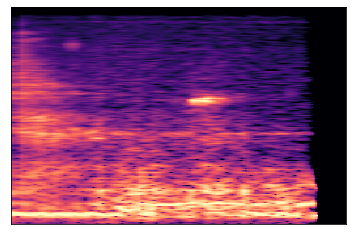

In [228]:
librosa.display.specshow(train.Specs[22])

In [209]:
train.sort_index()

,Specs,Label
1,"[[0.20309204, 0.216376, 0.24939203, 0.2938298,...",0
2,"[[0.3761812, 0.32084852, 0.44806755, 0.3651969...",0
3,"[[0.1889795, 0.23438877, 0.28810334, 0.3570773...",0
5,"[[0.42783523, 0.42634773, 0.42513722, 0.392839...",0
6,"[[0.5148676, 0.51730347, 0.518629, 0.51880187,...",0
...,...,...
524,"[[0.43088937, 0.42761385, 0.24394548, 0.106277...",1
526,"[[0.35957956, 0.35985112, 0.358788, 0.3572299,...",3
527,"[[0.5012927, 0.503229, 0.48023248, 0.4658283, ...",3
529,"[[0.30204225, 0.36148322, 0.37569237, 0.221074...",1


In [227]:
train

,Specs,Label,Audio
22,"[[0.54559755, 0.522161, 0.50875556, 0.48390764...",0,"[-0.002319336, -0.0011291504, 0.0002746582, 0...."
109,"[[0.54564404, 0.56043994, 0.561149, 0.5209105,...",3,"[0.0010375977, 0.00076293945, 0.00030517578, -..."
201,"[[0.24673498, 0.24332839, 0.27808022, 0.281120...",3,"[0.0012207031, 0.0010986328, 0.0009765625, 0.0..."
83,"[[0.42611408, 0.4059474, 0.37038183, 0.3461507...",2,"[-0.0004272461, -0.0004272461, -0.00039672852,..."
502,"[[0.18419802, 0.20547199, 0.22555637, 0.243903...",1,"[-0.0011901855, -0.00079345703, 0.00045776367,..."
...,...,...,...
266,"[[0.5461414, 0.5689646, 0.59035945, 0.63969314...",3,"[0.0005493164, 3.0517578e-05, 3.0517578e-05, 0..."
79,"[[0.45420855, 0.44832993, 0.44002497, 0.431914...",2,"[0.008850098, 0.008514404, 0.008056641, 0.0076..."
295,"[[0.3773979, 0.4086728, 0.44719636, 0.47411835...",0,"[0.0002746582, 0.00030517578, 0.00036621094, 0..."
212,"[[0.29560924, 0.28284132, 0.26896912, 0.299399...",3,"[-0.0012207031, -0.0007324219, 0.00030517578, ..."
